In [9]:
import os
import math
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import random
import numpy as np
from torch.utils.data import DataLoader, Dataset

In [10]:
# Data-Set Loader
tar0 = torch.load('tar0_small.pt')           # Target dataset
x_in = torch.load('x_in_small.pt')           # Images in {t-1}, {t}, {t+1}
y_binary = torch.load('y_binary_small.pt')   # Binary target (simplification of tar0) 

In [17]:
device = torch.device( "cpu")

print(device)

cpu


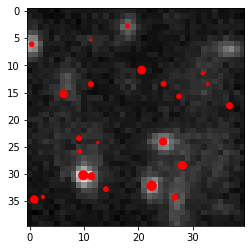

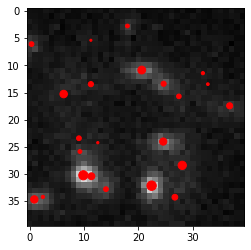

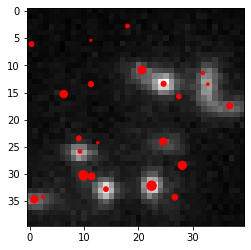

In [18]:
#### Visualizing the data ####
# Plotting input images x_{t-1}, x_{t}, x_{t+1} 
# with true label, bigger size of red dot means bigger brightness of the emitter

idx = 11
plt.imshow(x_in[idx,0,:,:], cmap='gray')
plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red')
plt.show()

plt.imshow(x_in[idx,1,:,:], cmap='gray')
plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red')
plt.show()

plt.imshow(x_in[idx,2,:,:], cmap='gray')
plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red')
plt.show()

In [19]:
def tripple_conv(in_chan, out_chan):
    conv =nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True)
    )
    return conv

def double_conv_sigmoid(in_chan, out_chan):
    conv =nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.Sigmoid()
    )
    return conv

def double_conv_tanh(in_chan, out_chan):
    conv =nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.Tanh()
    )
    return conv

In [20]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = tripple_conv(1, 48)
        self.down_conv_2 = tripple_conv(48, 96)
        self.down_conv_3 = tripple_conv(96, 192)

        self.up_trans_01 = nn.ConvTranspose2d(
            in_channels=192,
            out_channels=96,
            kernel_size=2,
            stride=2)
        
        self.up_conv_01 = tripple_conv(192, 96)
        
        self.up_trans_02= nn.ConvTranspose2d(
            in_channels=96,
            out_channels=48,
            kernel_size=2,
            stride=2)        
        
        self.up_conv_02 = tripple_conv(96, 48)
        
        #### 2nd temporal context module ####
    
        self.down_conv_11 = tripple_conv(144, 48)
        self.down_conv_12 = tripple_conv(48, 96)
        self.down_conv_13 = tripple_conv(96, 192)
        
        self.up_trans_11 = nn.ConvTranspose2d(
            in_channels=192,
            out_channels=96,
            kernel_size=2,
            stride=2)
        self.up_conv_11 = tripple_conv(192, 96)
        
        self.up_trans_12= nn.ConvTranspose2d(
            in_channels=96,
            out_channels=48,
            kernel_size=2,
            stride=2)         
        
        self.up_conv_12 = tripple_conv(96, 48)   
        
        #### Head output ####


        self.out_coor_brightness =  double_conv_sigmoid(48, 1)    
     

    def forward(self, image):
        x01 = self.down_conv_1(image)
        x02 =  self.max_pool_2x2(x01)
        x03 = self.down_conv_2(x02)
        x04 =  self.max_pool_2x2(x03) 
        x05 = self.down_conv_3(x04)

        #decoder
        x11 = self.up_trans_01(x05)
        x12= self.up_conv_01(torch.cat([x11, x03], 1))
        x13 = self.up_trans_02(x12)
        x14 = self.up_conv_02(torch.cat([x13, x01], 1))
        return x14

    def temporal_context(self, image_t_min_1, image_t, image_t_plus_1):
        
        t_min_1 = self.forward(image_t_min_1)
        t = self.forward(image_t)
        t_plus_1 = self.forward(image_t_plus_1)
        output = torch.cat((t_min_1, t, t_plus_1), 1)
        return output

    def forward2(self, image_t_min_1, image_t, image_t_plus_1):
        image1 = self.temporal_context(image_t_min_1, image_t, image_t_plus_1)
        x21 = self.down_conv_11(image1) 
        x22 =  self.max_pool_2x2(x21) 
        x23 = self.down_conv_12(x22)    
        x24 =  self.max_pool_2x2(x23) 
        x25 = self.down_conv_13(x24)
       
        #decoder
        x31 = self.up_trans_11(x25)
        x32= self.up_conv_11(torch.cat([x31, x23], 1))
        x33 = self.up_trans_12(x32)
        x34 = self.up_conv_12(torch.cat([x33, x21], 1))                

        return x34   

    def mono_head(self, x_in):
        image_t_min_1 = torch.zeros((1, 1, 40, 40))
        image_t = torch.zeros((1, 1, 40, 40))
        image_t_plus_1 = torch.zeros((1, 1, 40, 40))

        image_t_min_1[0,0]=   x_in[0,:,:]   
        image_t[0,0]=   x_in[1,:,:]
        image_t_plus_1[0,0]=   x_in[2,:,:]
        
        head_split= self.forward2(image_t_min_1, image_t, image_t_plus_1)
        out_coordinates_brightness = self.out_coor_brightness(head_split)

        return out_coordinates_brightness
    

In [21]:
#### Defining model and showing architecture ####
if __name__ == "__main__":

    model_bolean = UNet()
    print(model_bolean)

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d

C:\Users\mahir\anaconda3\envs\decode_env\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


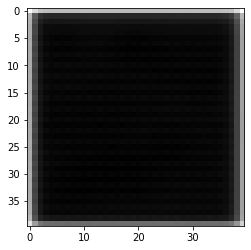

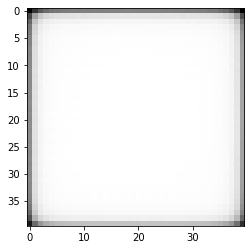

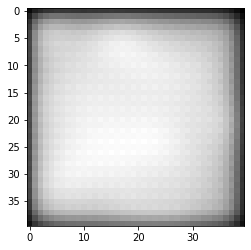

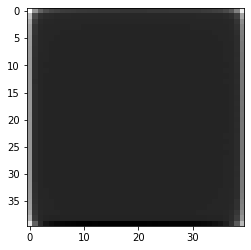

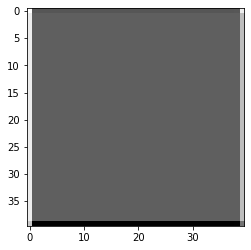

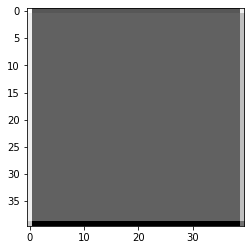

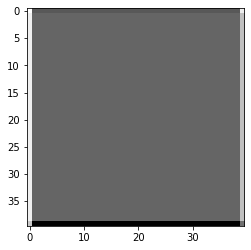

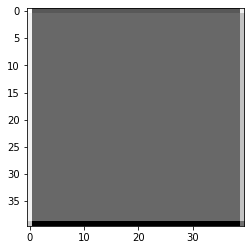

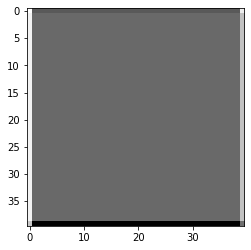

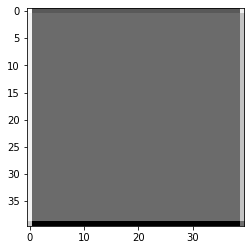

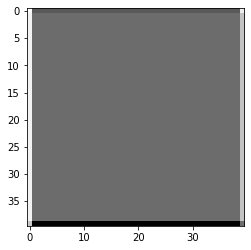

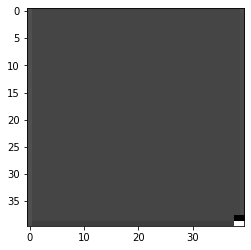

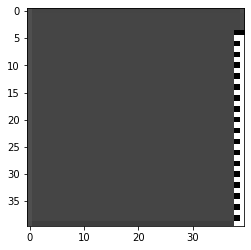

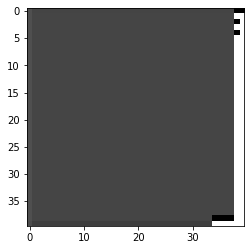

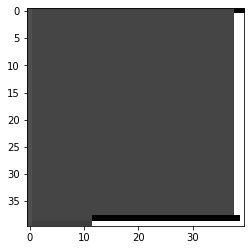

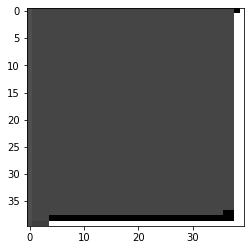

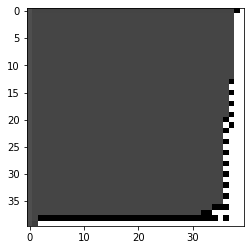

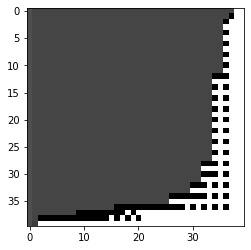

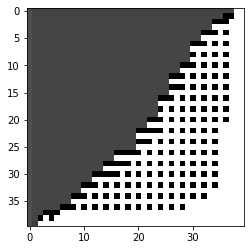

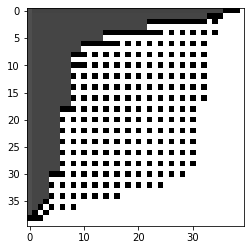

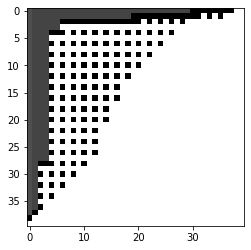

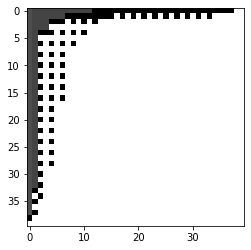

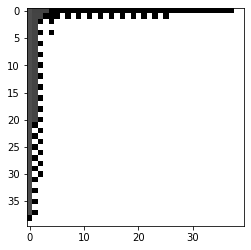

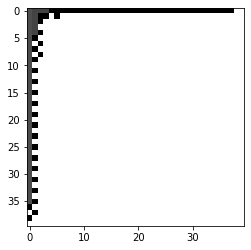

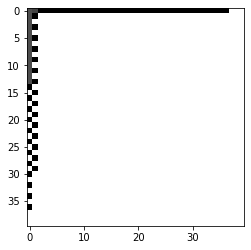

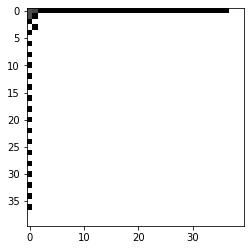

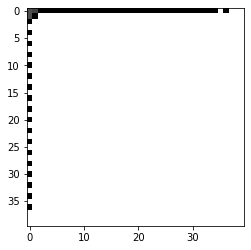

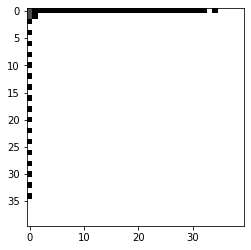

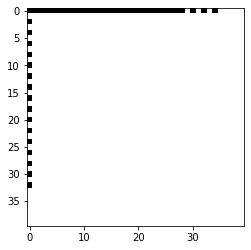

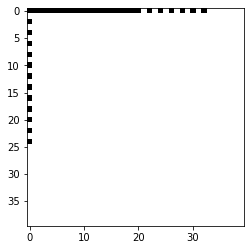

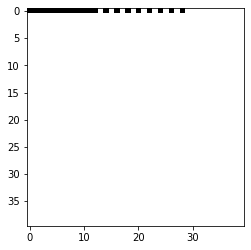

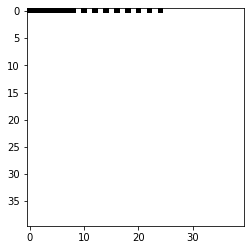

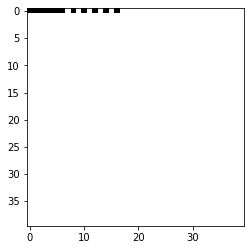

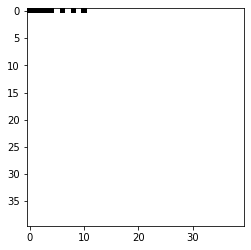

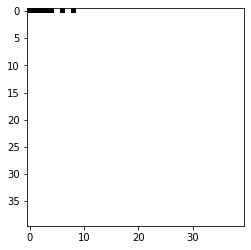

In [ ]:
### Simplified training of DECODE ###



amount_epoch = 50
amount_samples = 1#len(tar0)
epoch_set = 0

loss = nn.BCELoss()
optimizer = torch.optim.AdamW(model_bolean.parameters(), lr=0.003, betas=(0.9, 0.999), 
                              eps=1e-08, weight_decay=0.1, amsgrad=False)
for epoch in range(amount_epoch):
    epoch_set = epoch_set+1 
#     print('Epoch #', epoch_set)
    i = 0
    r = list(range(amount_samples))
    
    for idx in r:
        
        i = i + 1

#         if i == 500:
#             print('#training instance', i)
#         if i%1000 ==0:
#             print('#training instance', i)


        y_pred = model_bolean.mono_head(x_in[idx,:,:,:].to(device))
        y_pred = y_pred[0].to(device)
        y_pred = y_pred[0].to(device)

        random.shuffle(r)
        output = loss(y_pred.to(device), y_binary[idx,0,:,:].to(device))
        output.backward()
        optimizer.step()
        optimizer.zero_grad()
                ### Visualizing the results ###


        y_pred = model_bolean.mono_head(x_in[0,:,:,:])
        y_pred_np = y_pred.detach().numpy()
        plt.imshow(y_pred_np[0,0,:,:], cmap='gray')

        plt.show()

        


In [ ]:
### Visualizing the results ###
idx = 0
if __name__ == "__main__":

    
    y_pred = model_bolean.mono_head(x_in[0,:,:,:])
    y_pred_np = y_pred.detach().numpy()
    plt.imshow(y_pred_np[0,0,:,:], cmap='gray')
#     plt.scatter( tar0[idx,:,1], tar0[idx,:,2], s=300*tar0[idx,:,0], c='red', alpha=0.3)
    plt.show()
print(np.max(y_pred_np)) 
print(y_pred_np)